# Decision Tree Model

### Imports

In [1]:
! pip install graphviz
! pip install dl8.5
! pip install chefboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t

! pip install graphviz

from IPython.display import SVG
from graphviz import Source

from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

### Helper Functions

In [3]:
# ['No Urgent Place', 'Work', 'Home']
# ['Partner', 'Alone', 'Kid(s)', 'Friend(s)']
# ['Sunny', 'Rainy', 'Snowy']
# ['6PM', '7AM', '2PM', '10PM', '10AM']
# ['Bar', 'Restaurant(20-50)', 'Restaurant(<20)', 'Carry out & Take away', 'Coffee House']
# ['1d', '2h']
# ['Male', 'Female']
# ['31', '26', '50plus', '41', '21', 'below21', '36', '46']
# ['Married partner', 'Single', 'Unmarried partner', 'Divorced', 'Widowed']
# ['Some college - no degree', 'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)', 'High School Graduate', 'Some High School']
# ['Construction & Extraction', 'Unemployed', 'Arts Design Entertainment Sports & Media', 'Food Preparation & Serving Related', 'Education&Training&Library', 'Sales & Related', 'Computer & Mathematical', 'Student', 'Architecture & Engineering', 'Business & Financial', 'Office & Administrative Support', 'Retired', 'Management', 'Life Physical Social Science', 'Healthcare Support', 'Building & Grounds Cleaning & Maintenance', 'Legal', 'Installation Maintenance & Repair', 'Protective Service', 'Healthcare Practitioners & Technical', 'Community & Social Services', 'Transportation & Material Moving', 'Personal Care & Service', 'Farming Fishing & Forestry', 'Production Occupations']
# ['$100000 or More', '$62500 - $74999', '$37500 - $49999', '$12500 - $24999', '$25000 - $37499', '$75000 - $87499', '$50000 - $62499', '$87500 - $99999', 'Less than $12500']

# Driving_to,Passanger,Weather,Time,Coupon,Coupon_validity,Gender,Age,Maritalstatus,Education,Occupation,Income

translations = {
    'Driving_to' : ['No Urgent Place', 'Home', 'Work'],
    'Passanger' : ['Alone', 'Partner', 'Kid(s)', 'Friend(s)'],
    'Weather' : ['Sunny', 'Rainy', 'Snowy'],
    'Time' : ['7AM', '10AM', '2PM', '6PM', '10PM'],
    'Coupon' : ['Restaurant(<20)', 'Restaurant(20-50)', 'Carry out & Take away', 'Bar', 'Coffee House'],
    'Coupon_validity' : ['2h', '1d'],
    'Gender' : ['Male', 'Female'],
    'Age' : ['below21', '21', '26', '31', '36', '41', '46', '50plus'],
    'Maritalstatus' : ['Single', 'Divorced', 'Widowed', 'Unmarried partner', 'Married partner'],
    'Education' : ['Some High School', 'High School Graduate', 'Some college - no degree', 'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)'],
    'Occupation' : ['Unemployed', 'Construction & Extraction', 'Arts Design Entertainment Sports & Media', 'Food Preparation & Serving Related', 'Education&Training&Library', 'Sales & Related', 'Computer & Mathematical', 'Student', 'Architecture & Engineering', 'Business & Financial', 'Office & Administrative Support', 'Retired', 'Management', 'Life Physical Social Science', 'Healthcare Support', 'Building & Grounds Cleaning & Maintenance', 'Legal', 'Installation Maintenance & Repair', 'Protective Service', 'Healthcare Practitioners & Technical', 'Community & Social Services', 'Transportation & Material Moving', 'Personal Care & Service', 'Farming Fishing & Forestry', 'Production Occupations'],
    'Income' : ['Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999', '$50000 - $62499', '$62500 - $74999', '$75000 - $87499', '$87500 - $99999', '$100000 or More'],
}

def accuracy(y_actual, y_predicted):
    if(not len(y_actual) == len(y_predicted)):
        print("Lengths don't match")
        return 0
    correct = 0
    for i in range(len(y_actual)):
        if y_actual[i] == y_predicted[i]:
            correct += 1
    return 1.0 * correct / len(y_actual)

def clean_df(df):
    for (field, vals) in df.iteritems():
        for v_ind in vals.index:
            if pd.isna(vals[v_ind]):
                # NaN condition
                df.at[v_ind, field] = 0
        if field in translations:
            strings = []
            for s_ind in vals.index:
                if vals[s_ind] not in translations[field]:
                    # String that wasn't in training data
                    df.at[s_ind, field] = 0
                    continue
                df.at[s_ind, field] = translations[field].index(vals[s_ind])
    return df

### Data Importing and Processing

In [4]:
start_time = t.time()
df = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

# print(df)

### Data Processing

In [5]:
# Remove the id column

df = df.loc[:, df.columns != 'id']
df_test = df_test.loc[:, df_test.columns != 'id']

# Make string values into numbers

clean_df(df)
clean_df(df_test)

# Not 10 like normal since we already have a test partition
num_folds = 9 

cv_length = 1.0 * df.shape[0] / num_folds

partitions = [df.iloc[int(i * cv_length):int((i+1) * cv_length),:] for i in range(num_folds)]
# print([len(partitions[i]) for i in range(len(partitions))])


### Model

In [6]:
# Rotate the folds to tune the parameters

results = []
max_tree_depths = range(1, 50)

for i in range(num_folds):
    validation = partitions[i]
    training = pd.concat([j for j in partitions if not j.equals(validation)])
    
    y_train = training['Decision']
    X_train = training.loc[:, df.columns != 'Decision']
    
    y_valid = validation['Decision']
    X_valid = validation.loc[:, df.columns != 'Decision']
    
    results_for_fold = []
    
    for d in max_tree_depths:
        clf = tree.DecisionTreeClassifier()
        clf.criterion = 'entropy'
        clf.max_tree_depth = d
        clf.fit(X_train, y_train)
#         print("Prediction", clf.predict(X_valid))
#         print("Actual", np.array(y_valid))
        a = accuracy(np.array(y_valid), clf.predict(X_valid))
        results_for_fold += [a]
#         print("Accuracy for depth {:} in fold {:} is {:}".format(d, i, a))
    
    results += [results_for_fold]

# print(results)

results_for_d = np.array(results).T

# print(results_for_d)

min_acc = []
max_acc = []
avg_acc = []

for ind_d in range(len(max_tree_depths)):
    min_acc += [np.min(results_for_d[ind_d])]
    max_acc += [np.max(results_for_d[ind_d])]
    avg_acc += [np.mean(results_for_d[ind_d])]
    print("For depth {:3d}: Avg: {:4f} | Min: {:4f} | Max {:4f}".format(max_tree_depths[ind_d], avg_acc[ind_d], min_acc[ind_d], max_acc[ind_d]))
        
optimal_depth = max_tree_depths[avg_acc.index(np.max(avg_acc))]
print("Optimal max tree depth:", optimal_depth)


For depth   1: Avg: 0.675960 | Min: 0.649867 | Max 0.688163
For depth   2: Avg: 0.678513 | Min: 0.661362 | Max 0.690813
For depth   3: Avg: 0.678710 | Min: 0.656941 | Max 0.687887
For depth   4: Avg: 0.681949 | Min: 0.659593 | Max 0.696996
For depth   5: Avg: 0.677630 | Min: 0.649867 | Max 0.691696
For depth   6: Avg: 0.675666 | Min: 0.651636 | Max 0.685234
For depth   7: Avg: 0.678416 | Min: 0.656057 | Max 0.690813
For depth   8: Avg: 0.678317 | Min: 0.655172 | Max 0.689929
For depth   9: Avg: 0.678513 | Min: 0.656057 | Max 0.691696
For depth  10: Avg: 0.675666 | Min: 0.650752 | Max 0.691696
For depth  11: Avg: 0.680380 | Min: 0.656941 | Max 0.692308
For depth  12: Avg: 0.680672 | Min: 0.647215 | Max 0.695230
For depth  13: Avg: 0.678023 | Min: 0.657825 | Max 0.694076
For depth  14: Avg: 0.679594 | Min: 0.652520 | Max 0.692580
For depth  15: Avg: 0.678710 | Min: 0.656057 | Max 0.690813
For depth  16: Avg: 0.677826 | Min: 0.648983 | Max 0.695230
For depth  17: Avg: 0.677727 | Min: 0.65

### Visualization

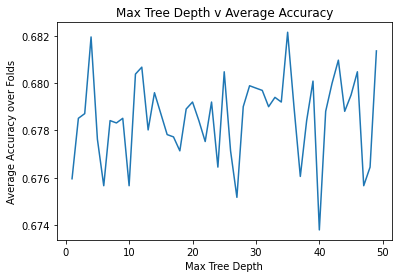

In [10]:
plt.plot(max_tree_depths, avg_acc)
plt.title("Max Tree Depth v Average Accuracy")
plt.xlabel("Max Tree Depth")
plt.ylabel("Average Accuracy over Folds")
plt.savefig('decision_tree.png')
plt.show()

### Test

In [8]:
X_test = df_test.loc[:, df_test.columns != 'Decision']

y_train = df['Decision']
X_train = df.loc[:, df.columns != 'Decision']

clf = tree.DecisionTreeClassifier()
clf.criterion = 'entropy'
clf.max_tree_depth = optimal_depth

clf.fit(X_train, y_train)
results = clf.predict(X_test)
print("Runtime is {:} seconds".format(t.time() - start_time))

Runtime is 21.359911918640137 seconds


### Format for Output

In [9]:
df_test['Decision'] = results
df_test['id'] = range(1, df_test.shape[0] + 1)
df_test = df_test[['id', 'Decision']]
print(df_test)

df_test.to_csv(r"../data/decision_tree_results.csv", index = False)

        id  Decision
0        1         0
1        2         1
2        3         0
3        4         1
4        5         1
...    ...       ...
2495  2496         0
2496  2497         0
2497  2498         1
2498  2499         1
2499  2500         0

[2500 rows x 2 columns]
